# Data Prep

## Data Fetch From Trino


In [1]:
"""
This script establishes a connection to a Presto database via the Trino Python client, 
executes a SQL query to fetch data, and then structures the fetched data into a pandas DataFrame.
The DataFrame is organized with appropriate column names, making the data ready for analysis.
"""

import trino
import pandas as pd
import getpass

# Get password
password = getpass.getpass("Enter your password: ")

# Connect to Trino
conn = trino.dbapi.connect(
    host="presto-gateway.corp.mongodb.com",
    port=443,
    user="jiawei.zhou@mongodb.com",
    catalog="awsdatacatalog",
    http_scheme="https",
    auth=trino.auth.BasicAuthentication("jiawei.zhou@mongodb.com", password),
)

# Execute query
cur = conn.cursor()

/Users/jiawei.zhou/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# Step 1 - To delete the table 'jz_ddp_analysis_aoption_info' from the 'product_analytics' schema in the 'awsdatacatalog' database.

cur.execute(
    f"""
drop table if exists awsdatacatalog.product_analytics.jz_ddp_analysis_aoption_info_cluster_level
"""
)

In [3]:
# Step 2 - To generate a table summarizing the adoption of DDP at the cluster level

cur.execute(
    f"""
create table awsdatacatalog.product_analytics.jz_ddp_analysis_aoption_info_cluster_level as (

with clusters as (
select
	distinct(cluster_id) as cluster_id
from
	awsdatacatalog.data_science.prod_production_identification_results
where
	measured_at = date '2023-01-01'
	and production_flag = true
	), 
search as (
select
	ds,
	cluster_id,
	max(qualification_flg) as search_qualified
from
	awsdatacatalog.product_analytics.analytics__atlas_search_mbr_base_data_static_v2
where
	ds = date('2023-01-01')
group by
	1,
	2),
device_sync_mapping as (
select
	*
from
	awsdatacatalog.ns__analytics_postprocessing.analytics__realm__apps
cross join unnest(SPLIT(cluster_ids,
	',')) T (cluster_id)
),
device_sync_temp as (
select
	granularity,
	granularity_id,
	device_sync_mapping.cluster_ids,
	mrr.cluster_id,
	active_7d_usage,
	lness_30d,
	mrr.mrr__total,
	mrr.sales_channel,
	case
		when active_7d_usage >= 300
			and lness_30d >= 21 then 1
			else 0
		end as qualification_flg,
		case
			when lness_30d >= 10 then 1
			else 0
		end as activation_flg,
		case
			when active_7d_usage > 0 then 1
			else 0
		end as adopted_flg,
		ds
	from
		awsdatacatalog.ns__analytics_postprocessing.analytics__atlas_realm_feature_usage_dim real_usage_dim
	join device_sync_mapping device_sync_mapping on
		real_usage_dim.granularity_id = device_sync_mapping.appid
	left join awsdatacatalog.ns__analytics_postprocessing.analytics__atlas__mrr_daily mrr on
		device_sync_mapping.cluster_id = mrr.cluster_id
		and date(ds) = date(mrr.usage_date)
	join awsdatacatalog.xform_cloud.cloud_cluster_org_dateversioned_v v on
		device_sync_mapping.cluster_id = v.cluster_id
			and date(ds) = date(v.partition_date)
		where
			ds = date('2023-01-01')
				and granularity = 'app'
				and real_usage_dim.product = 'Sync'
				and v.instance_size not in ('M0', 'M2', 'M5')
),
device_sync as (
select
	ds,
	cluster_id,
	MAX(qualification_flg) as device_sync_qualified
from
	device_sync_temp
group by
	1,
	2
),
time_series as (
select
	ds,
	cluster_id,
	max(qualification_flg) as timeseries_qualified
from
	(
	select
		ds,
		granularity_id as cluster_id,
		c.org_id,
		case
			when active_7d_usage >= 300
				and lness_30d >= 21 then 1
				else 0
			end as qualification_flg
		from
			awsdatacatalog.ns__analytics_postprocessing.analytics__time_series_usage_dim a
		left join awsdatacatalog.ns__analytics_postprocessing.analytics__atlas__mrr_daily m on
			a.granularity_id = m.cluster_id
			and date(m.usage_date) = a.ds
		left join awsdatacatalog.xform_cloud.cloud_cluster_org_dateversioned_v c on
			a.granularity_id = c.cluster_id
				and date(ds) = date(c.partition_date)
			where
				ds = date('2023-01-01')
					and active_7d_usage >= 300
					and lness_30d >= 21
					and granularity = 'cluster'
					and m.cluster_id <> 'nan'
) t
group by
	1,
	2)
select
	base.cluster_id,
	coalesce(search_qualified,
	0) as search_qualified,
	coalesce(timeseries_qualified,
	0) as timeseries_qualified,
	coalesce(device_sync_qualified,
	0)as device_sync_qualified
from
	clusters base
left join search search on
	base.cluster_id = search.cluster_id
left join time_series time_series on
	base.cluster_id = time_series.cluster_id
left join device_sync device_sync on
	base.cluster_id = device_sync.cluster_id)
"""
)

In [4]:
# Step 3 - To gather supplementary data for the analysis

cur.execute(
    f"""
with adoption_info as (
select
	*
from
	awsdatacatalog.product_analytics.jz_ddp_analysis_aoption_info_cluster_level
),
cluster_info as (
select
	org_id,
	org_name,
	cluster_id,
	created_at,
	deleted_at,
	cloudprovider,
	array_join(region, ',') AS region,
	instance_size,
	tier,
	is_deleted,
	topology,
	replicaset_count,
	is_sharding,
	shard_count,
	is_global_cluster,
	cluster_mdb_major_version,
	disk_size_gb,
	cluster_state
from
	awsdatacatalog.xform_cloud.cluster_dim_dateversioned_v
where
	processed_date = date'2023-01-01'
	and is_internal_org = false
),
mrr_info as (
select
	*
from
	(
	select
		cluster_id,
		org_id,
		sales_channel,
		environment,
		cloud_provider,
		mrr__total,
		date_trunc('month',
		usage_date) as month,
		row_number() over (
            partition by cluster_id,
		date_trunc('month',
		usage_date)
	order by
		mrr__total desc
        ) as rn
	from
		awsdatacatalog.ns__analytics_postprocessing.analytics__atlas__mrr_daily
	where
		usage_date = date'2023-01-01'
) as subquery
where
	rn = 1
),
churn_info as (
select
	cluster_id,
	deleted_at, 
	date_trunc('month',
	processed_date) as churn_month,
	case
		when deleted_at is not null then 1
		else 0
	end as churn_ind
from
	awsdatacatalog.xform_cloud.cluster_dim_dateversioned_v
where
	extract(year
from
	processed_date) = 2023
	and extract(month
from
	processed_date) between 1 and 12
	and extract(day
from
	processed_date)= 1
)
select
	*,
	DATE_DIFF('month',
	t2.created_at,
	date'2023-01-01'
	) 
    as cluster_tenure_in_months
from
	adoption_info t1
join cluster_info t2 on
	t1.cluster_id = t2.cluster_id
left join mrr_info t3 on
	t1.cluster_id = t3.cluster_id
left join churn_info t4 on
	t1.cluster_id = t4.cluster_id
"""
)

# Extract column names
columns = [desc[0] for desc in cur.description]

# Fetch rows
rows = cur.fetchall()

# Create DataFrame
df_raw = pd.DataFrame(rows, columns=columns)

## Data Prep Pipeline


In [ ]:
# Configure pandas display options for maximum rows and columns

# Set the maximum number of displayed rows
pd.set_option("display.max_rows", 100)  # For example, display up to 100 rows

# Set the maximum number of displayed columns
pd.set_option("display.max_columns", 50)  # For example, display up to 50 columns

In [5]:
# Create a copy of the original DataFrame and display the first few rows.

df = df_raw.copy()

# Display rows
df.head()

,cluster_id,search_qualified,timeseries_qualified,device_sync_qualified,org_id,org_name,cluster_id,created_at,deleted_at,cloudprovider,...,environment,cloud_provider,mrr__total,month,rn,cluster_id,deleted_at,churn_month,churn_ind,cluster_tenure_in_months
0,5be07d8e9ccf647e29379f89,0,0,0,5bbf71e079358eeb807a3ce6,Global,5be07d8e9ccf647e29379f89,2018-11-05 17:27:42.751,NaT,[AWS],...,Commercial,AWS,328.662222,2023-01-01,1.0,5be07d8e9ccf647e29379f89,NaT,2023-03-01,0,49
1,5be07d8e9ccf647e29379f89,0,0,0,5bbf71e079358eeb807a3ce6,Global,5be07d8e9ccf647e29379f89,2018-11-05 17:27:42.751,NaT,[AWS],...,Commercial,AWS,328.662222,2023-01-01,1.0,5be07d8e9ccf647e29379f89,NaT,2023-02-01,0,49
2,5be07d8e9ccf647e29379f89,0,0,0,5bbf71e079358eeb807a3ce6,Global,5be07d8e9ccf647e29379f89,2018-11-05 17:27:42.751,NaT,[AWS],...,Commercial,AWS,328.662222,2023-01-01,1.0,5be07d8e9ccf647e29379f89,NaT,2023-05-01,0,49
3,5be07d8e9ccf647e29379f89,0,0,0,5bbf71e079358eeb807a3ce6,Global,5be07d8e9ccf647e29379f89,2018-11-05 17:27:42.751,NaT,[AWS],...,Commercial,AWS,328.662222,2023-01-01,1.0,5be07d8e9ccf647e29379f89,NaT,2023-11-01,0,49
4,5be07d8e9ccf647e29379f89,0,0,0,5bbf71e079358eeb807a3ce6,Global,5be07d8e9ccf647e29379f89,2018-11-05 17:27:42.751,NaT,[AWS],...,Commercial,AWS,328.662222,2023-01-01,1.0,5be07d8e9ccf647e29379f89,NaT,2023-09-01,0,49


In [7]:
# Remove duplicate columns from the DataFrame

# Find duplicate column names
duplicates = df.columns[df.columns.duplicated(keep=False)]

# Drop duplicate columns
df = df.loc[:, ~df.columns.duplicated()]

In [8]:
# Cleans and transforms a dataset for analysis

import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportion_confint

# Ensure cluster_id is a column, not an index
if "cluster_id" not in df.columns:
    df = df.reset_index()

# Drop any duplicate columns, especially 'cluster_id' if it's duplicated
df = df.loc[:, ~df.columns.duplicated()]

# Convert 'month' to datetime and format it as yyyy-mm-dd
df["churn_month"] = pd.to_datetime(df["churn_month"]).dt.date

# Create a pivot table with cluster_id as rows, month as columns, and monthly_churn_indicator as values
pivot_df = df.pivot_table(
    index="cluster_id",
    columns="churn_month",
    values="churn_ind",
    fill_value=1,
    aggfunc="first",
)

# Prepare unique_df by dropping columns related to churn and month, and dropping duplicate cluster_id
columns_to_exclude = ["churn_month", "churn_ind"]
unique_df = df.drop(columns=columns_to_exclude).drop_duplicates(subset="cluster_id")

# Rename pivot_df columns to include 'churn_ind' prefix
pivot_df.columns = ["churn_ind_" + col.strftime("%Y_%m") for col in pivot_df.columns]

# Join unique_df with pivot_df on 'cluster_id'
df = unique_df.join(pivot_df, on="cluster_id")

# Reset index to make 'cluster_id' a column again
df.reset_index(inplace=True)

# Display the first few rows of the modified DataFrame
df.head()

,index,cluster_id,search_qualified,timeseries_qualified,device_sync_qualified,org_id,org_name,created_at,deleted_at,cloudprovider,region,instance_size,tier,is_deleted,topology,replicaset_count,is_sharding,shard_count,is_global_cluster,cluster_mdb_major_version,disk_size_gb,cluster_state,sales_channel,environment,cloud_provider,mrr__total,month,rn,cluster_tenure_in_months,churn_ind_2023_01,churn_ind_2023_02,churn_ind_2023_03,churn_ind_2023_04,churn_ind_2023_05,churn_ind_2023_06,churn_ind_2023_07,churn_ind_2023_08,churn_ind_2023_09,churn_ind_2023_10,churn_ind_2023_11,churn_ind_2023_12
0,0,5be07d8e9ccf647e29379f89,0,0,0,5bbf71e079358eeb807a3ce6,Global,2018-11-05 17:27:42.751,NaT,[AWS],US_EAST_1,M20,PAID,False,REPLICASET,1,False,1,False,4.4,69.0,IDLE,self-serve,Commercial,AWS,328.662222,2023-01-01,1.0,49,0,0,0,0,0,0,0,0,0,0,0,0
1,12,62178cce28c0623c94d12a5d,0,0,0,5ddbf29379358e57411f8c4d,boomtownroi.com - Atlas,2022-02-24 13:49:02.099,NaT,[AWS],US_EAST_1,M30,PAID,False,REPLICASET,1,False,1,False,4.4,30.0,IDLE,self-serve,Commercial,AWS,395.264583,2023-01-01,1.0,10,0,0,0,0,0,0,0,0,0,0,0,0
2,24,636919f15dc0ae655d672b9e,0,0,0,60cb6231848c036fd1798649,Auth0 Layer0 Prod,2022-11-07 14:45:05.049,NaT,[AWS],US_EAST_1,M10,PAID,False,REPLICASET,1,False,1,False,4.2,32.0,IDLE,sales-sold,Commercial,AWS,68.265139,2023-01-01,1.0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,36,59761cc34e65816ae487a9b9,0,0,0,599eed1e9f78f769464d1b13,Blitzrocks (Organization),2017-07-24 16:13:55.750,NaT,[AZURE],US_WEST,M10,PAID,False,REPLICASET,1,False,1,False,4.2,128.0,IDLE,sales-sold,Commercial,AZURE,187.174028,2023-01-01,1.0,65,0,0,0,0,0,0,0,0,0,0,0,0
4,48,6272b4ba85adca64f46536d7,0,0,0,5e1ca61fa6f23917fb892408,InretailPharma S.A.,2022-05-04 17:15:38.381,NaT,[GCP],EASTERN_US,M30,PAID,False,REPLICASET,1,False,1,False,5.0,40.0,IDLE,sales-sold,Commercial,GCP,403.963750,2023-01-01,1.0,7,0,0,0,0,0,0,0,0,0,0,0,0


# Data Analysis

## Data Profiling


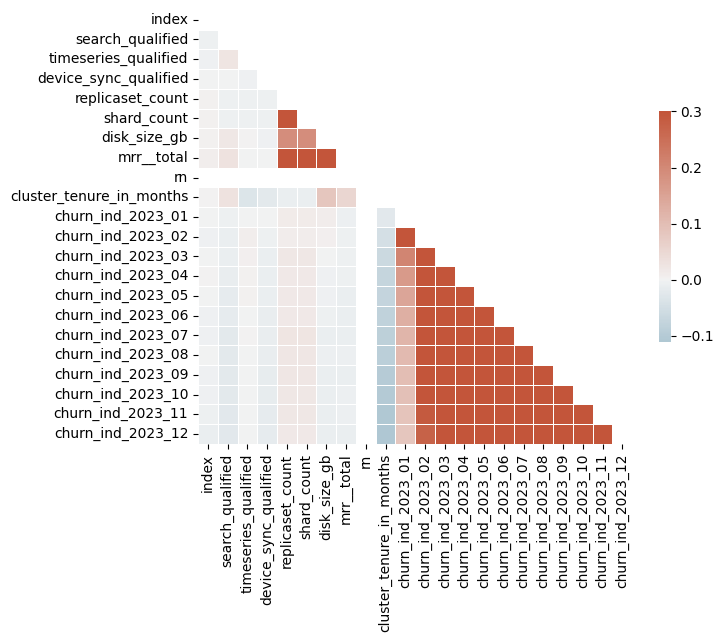

In [9]:
# Visualizes the correlation matrix of numeric columns in a DataFrame as a heatmap.

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Select only numeric columns
df_numeric = df.select_dtypes(include=[np.number])

# Compute the correlation matrix
corr = df_numeric.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure with a smaller size
f, ax = plt.subplots(figsize=(7, 6))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(
    corr,
    mask=mask,
    cmap=cmap,
    vmax=0.3,
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
)
plt.show()

In [10]:
# Calculate and display missing values in a DataFrame

# Calculate the count and percentage of missing values
missing_count = df.isnull().sum()
missing_percentage = 100 * df.isnull().sum() / len(df)

# Create a DataFrame with the results
missing_values_df = pd.DataFrame(
    {"count": missing_count, "percentage": missing_percentage}
)

# Format the 'percentage' column as a percentage
missing_values_df["percentage"] = missing_values_df["percentage"].map("{:.2f}%".format)

# Filter to only show columns with missing values
missing_values_df = missing_values_df[missing_values_df["count"] > 0]

print(missing_values_df)

                count percentage
deleted_at      47612     99.89%
sales_channel      46      0.10%
environment         4      0.01%
cloud_provider     46      0.10%
mrr__total          4      0.01%
month               4      0.01%
rn                  4      0.01%


In [ ]:
## Data 

In [11]:
# Display the counts and the adoption percentages for each product

# Calculate the total number of clusters
total_clusters = len(df)

# Calculate the adoption counts and percentages for each individual product
product_columns = ["search_qualified", "timeseries_qualified", "device_sync_qualified"]
adoption_counts = df[product_columns].sum()
adoption_percentage = (adoption_counts / total_clusters) * 100

# Add a new column 'sum_adoption' that is the sum of all product columns
df["sum_adoption"] = df[product_columns].sum(axis=1)

# Count how many clusters have adopted any product at all
any_adoption_count = (df["sum_adoption"] > 0).sum()
any_adoption_percentage = (any_adoption_count / total_clusters) * 100

# Add the total count row to the adoption_summary DataFrame
adoption_summary = pd.DataFrame(
    {
        "Product": product_columns + ["any_product", "total_clusters"],
        "Adoption_Count": adoption_counts.tolist()
        + [any_adoption_count, total_clusters],
        "Adoption_Percentage (%)": adoption_percentage.tolist()
        + [any_adoption_percentage, 100],
    }
)

# Format the 'Adoption_Percentage (%)' column as a percentage
adoption_summary["Adoption_Percentage (%)"] = adoption_summary[
    "Adoption_Percentage (%)"
].map("{:.2f}%".format)

adoption_summary

,Product,Adoption_Count,Adoption_Percentage (%)
0,search_qualified,1399,2.94%
1,timeseries_qualified,192,0.40%
2,device_sync_qualified,169,0.35%
3,any_product,1736,3.64%
4,total_clusters,47666,100.00%


In [12]:
# Count the number of clusters that have adopted 1, 2, 3, or 4 products

# Calculate the total number of clusters
total_clusters = len(df)

# Get the value counts for 'sum_adoption'
product_adoption_counts = df["sum_adoption"].value_counts()

# Calculate the percentage of clusters
product_adoption_percentage = (product_adoption_counts / total_clusters) * 100

# Create a DataFrame to display the counts and percentages
product_adoption_summary = pd.DataFrame(
    {
        "Number of Products Adopted": product_adoption_counts.index,
        "Number of Clusters": product_adoption_counts.values,
        "Percentage of Clusters (%)": product_adoption_percentage.values,
    }
)

# Format the 'Percentage of Clusters (%)' column as a percentage
product_adoption_summary["Percentage of Clusters (%)"] = product_adoption_summary[
    "Percentage of Clusters (%)"
].map("{:.2f}%".format)

# Display the summary
product_adoption_summary

,Number of Products Adopted,Number of Clusters,Percentage of Clusters (%)
0,0,45930,96.36%
1,1,1712,3.59%
2,2,24,0.05%


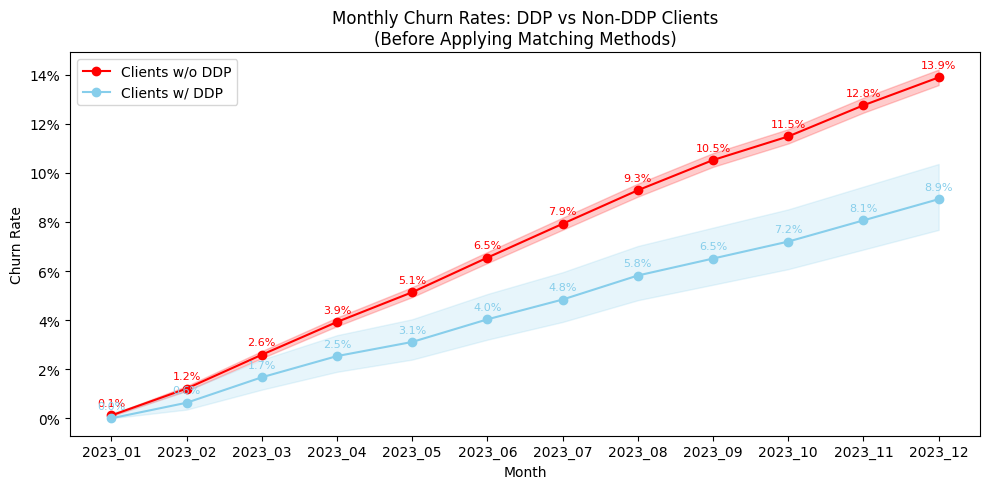

In [13]:
# Visualizes churn rates comparing clients with any versus no digital product adoption, including confidence intervals.

# import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from statsmodels.stats.proportion import proportion_confint

# Define the conditions to group by
conditions = ["search_qualified", "timeseries_qualified", "device_sync_qualified"]

# Create a new column 'any_product' which is 1 if any of the above conditions is 1
df["any_product"] = df[conditions].max(axis=1)

# Create a copy of the original DataFrame
df_backup = df.copy()

# Find all columns that contain churn indicators
churn_columns = [col for col in df.columns if "churn_ind" in col]

# Color settings: reversing the colors for 0 and 1
colors = {"0": "red", "1": "skyblue"}


# Define a function to calculate churn rate and plot with annotations
def plot_churn_rate_by_any_product():
    plt.figure(figsize=(10, 5))
    plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{y:.0%}"))

    for value in [0, 1]:
        filtered_df = df[df["any_product"] == value]

        churn_rates = []
        lower_cis = []
        upper_cis = []
        months = []

        for column in churn_columns:
            churned = filtered_df[column].sum()
            total = len(filtered_df)
            rate = churned / total
            churn_rates.append(rate)
            lower_ci, upper_ci = proportion_confint(
                churned, total, alpha=0.05, method="wilson"
            )
            lower_cis.append(lower_ci)
            upper_cis.append(upper_ci)
            months.append(column[-7:])

        label = f"Clients {'w/o' if value == 0 else 'w/'} DDP"
        plt.plot(months, churn_rates, marker="o", label=label, color=colors[str(value)])
        plt.fill_between(
            months, lower_cis, upper_cis, alpha=0.2, color=colors[str(value)]
        )

        for i, rate in enumerate(churn_rates):
            plt.text(
                months[i],
                rate + 0.003,
                f"{rate:.1%}",
                ha="center",
                va="bottom",
                fontsize=8,
                color=colors[str(value)],
            )

    plt.title(
        "Monthly Churn Rates: DDP vs Non-DDP Clients\n(Before Applying Matching Methods)"
    )
    plt.xlabel("Month")
    plt.ylabel("Churn Rate")
    # plt.xticks(rotation=45)
    plt.grid(False)
    plt.legend()
    plt.tight_layout()


# Plot churn rate for 'any_product'
plot_churn_rate_by_any_product()
plt.show()

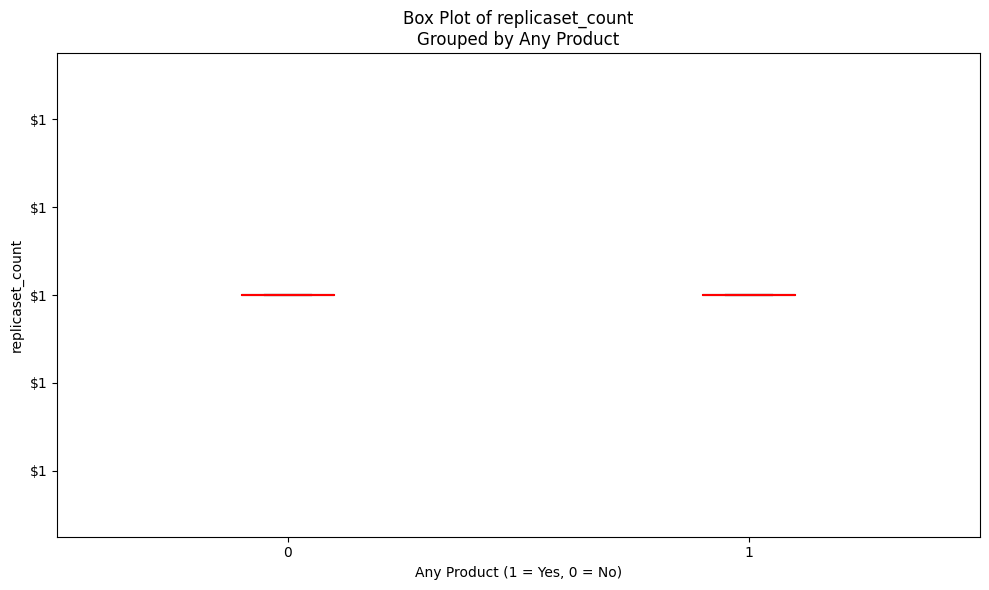

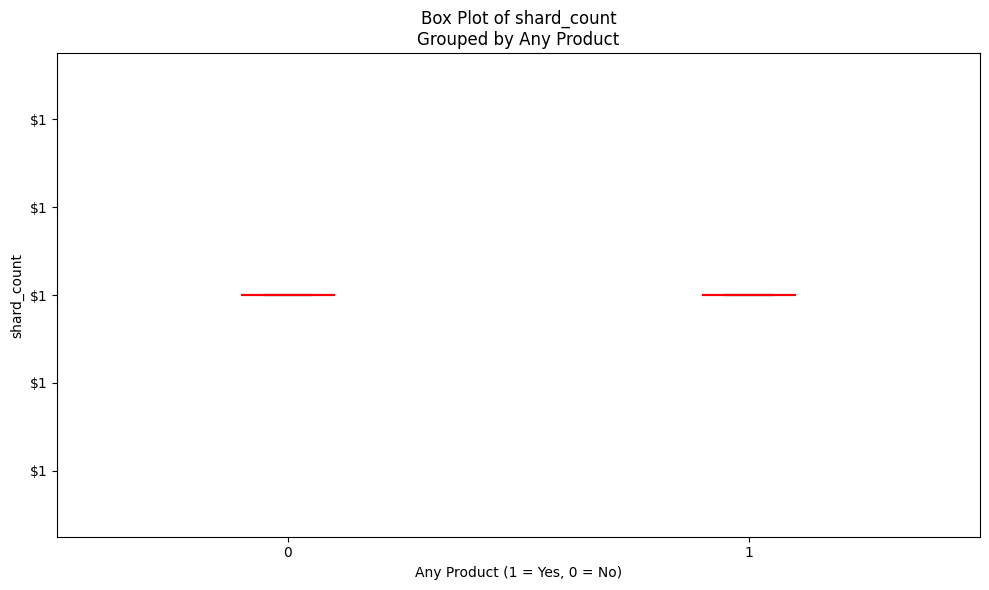

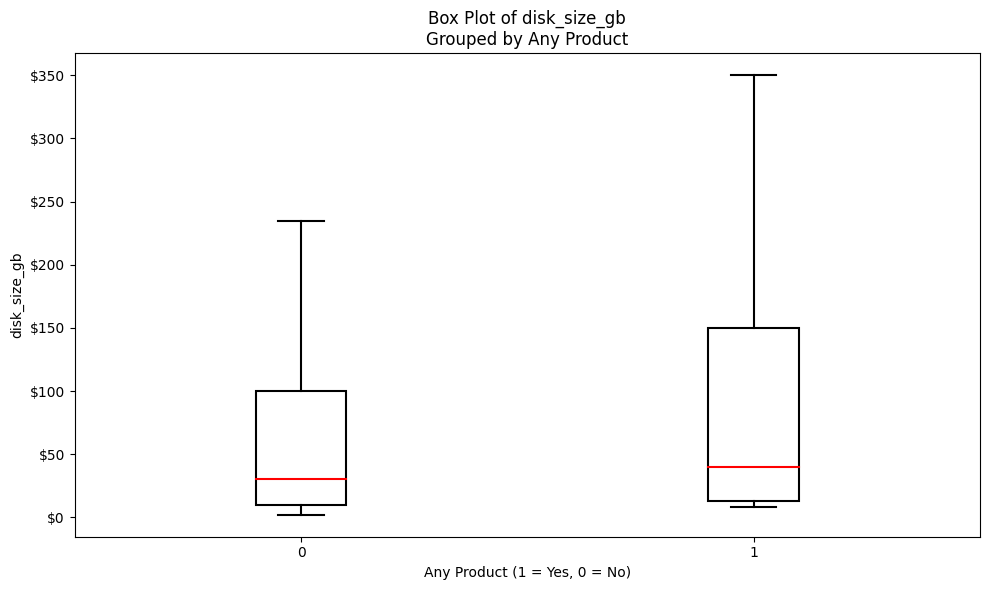

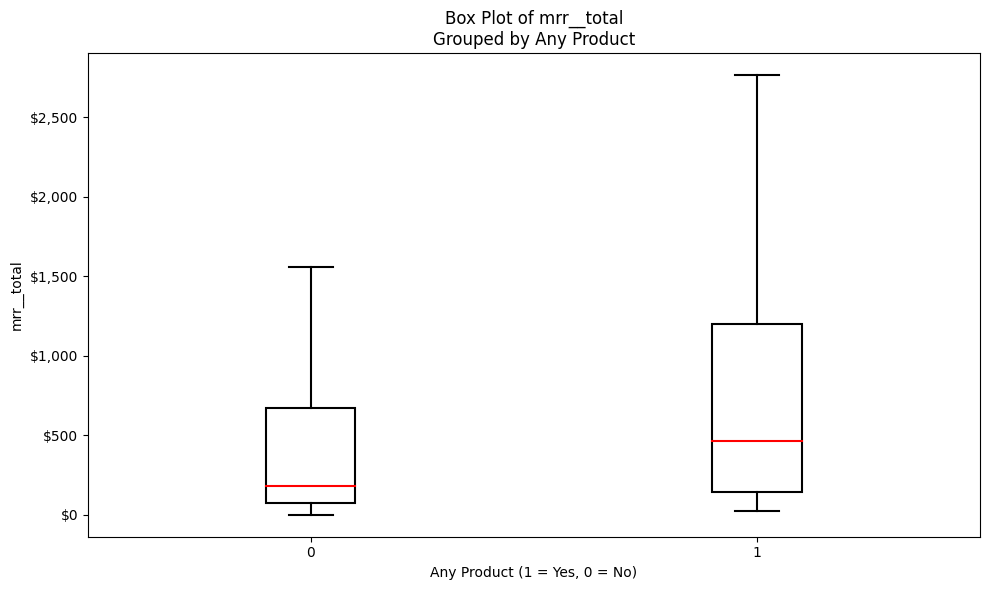

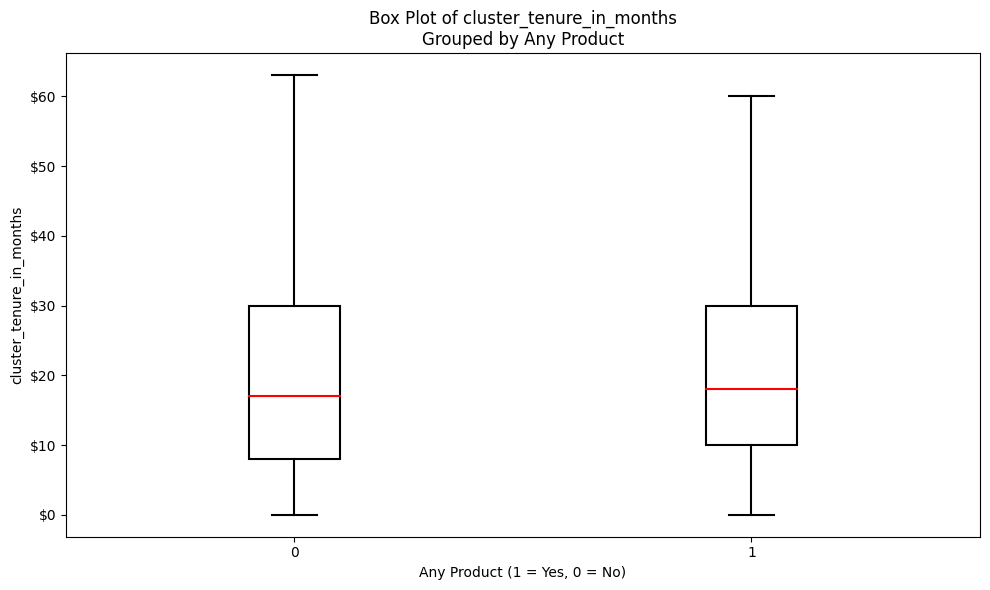

In [14]:
# Generates box plots for various numerical metrics

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# List of numerical columns for boxplot
numerical_columns = [
    "disk_size_gb",
    "mrr__total",
    "cluster_tenure_in_months",
]

# Define a formatter for y-axis
formatter = FuncFormatter(lambda y, _: f"${y:,.0f}")

# Filtering the DataFrame for relevant columns
filtered_df = df[numerical_columns + ["any_product"]]

# Plotting boxplots for each numerical column
for column in numerical_columns:
    # Skip if the column is categorical
    if filtered_df[column].dtype == "object":
        continue

    plt.figure(figsize=(10, 6))
    ax = plt.gca()
    ax.yaxis.set_major_formatter(formatter)

    sns.boxplot(
        x="any_product",
        y=column,
        data=filtered_df,
        showfliers=False,
        linewidth=1.5,
        color="black",
        boxprops=dict(facecolor="none"),
        width=0.2,
        medianprops=dict(color="red"),
    )

    ax.set_title(f"Box Plot of {column}\nGrouped by Any Product")
    ax.set_xlabel("Any Product (1 = Yes, 0 = No)")
    ax.set_ylabel(column)

    plt.tight_layout()
    plt.show()

# Matching Methodology Pipeline

In [15]:
# Analyzes missing data in key database cluster attributes, calculating and displaying the count and percentage of missing values for selected columns.

# List of columns to check for missing values
columns_to_check = [
    "region",
    "instance_size",
    "topology",
    "cluster_mdb_major_version",
    "disk_size_gb",
    "sales_channel",
    "cloud_provider",
    "mrr__total",
    "cluster_tenure_in_months",
    "any_product",
]

# Calculate the count and percentage of missing values for the specified columns
missing_count = df[columns_to_check].isnull().sum()
missing_percentage = 100 * df[columns_to_check].isnull().sum() / len(df)

# Create a DataFrame with the results
missing_values_df = pd.DataFrame(
    {"count": missing_count, "percentage": missing_percentage}
)

# Format the 'percentage' column as a percentage
missing_values_df["percentage"] = missing_values_df["percentage"].map("{:.2f}%".format)

# Filter to only show columns with missing values
missing_values_df = missing_values_df[missing_values_df["count"] > 0]

print(missing_values_df)

                count percentage
sales_channel      46      0.10%
cloud_provider     46      0.10%
mrr__total          4      0.01%


In [16]:
# Prepares and models data to predict binary outcomes with XGBoost, incorporating preprocessing for numerical and categorical data, handling imbalances with SMOTE, and calculating propensity scores.

import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Select only the columns of interest including the outcome variable
df = df[columns_to_check]

# Drop features with more than 1% missing values
threshold = 0.01
df = df.loc[:, df.isnull().mean() < threshold]

# Drop rows with any remaining missing values
df = df.dropna()

# Define the outcome variable
outcome = "any_product"

# Identify categorical and numerical columns
categorical_features = [
    col for col in df.columns if df[col].dtype == "object" and col != outcome
]
numerical_features = [
    col for col in df.columns if col not in categorical_features and col != outcome
]

# Split data into training and testing sets
X = df.drop(outcome, axis=1)
y = df[outcome].astype(int)  # Make sure the outcome is binary (0 or 1)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Create preprocessing pipelines for both numerical and categorical data
numerical_transformer = Pipeline(steps=[("scaler", StandardScaler())])
categorical_transformer = Pipeline(
    steps=[
        (
            "label",
            OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=np.nan),
        )
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

# Create the modeling pipeline with SMOTE and XGBoost
model = ImbPipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("smote", SMOTE(random_state=42)),
        (
            "classifier",
            xgb.XGBClassifier(
                objective="binary:logistic",
                eval_metric="logloss",
                use_label_encoder=False,
                random_state=42,
            ),
        ),
    ]
)

# Fit the model
model.fit(X_train, y_train)

# Calculate propensity scores for the entire dataset
propensity_scores = model.predict_proba(X)[:, 1]
df["propensity_score"] = propensity_scores

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


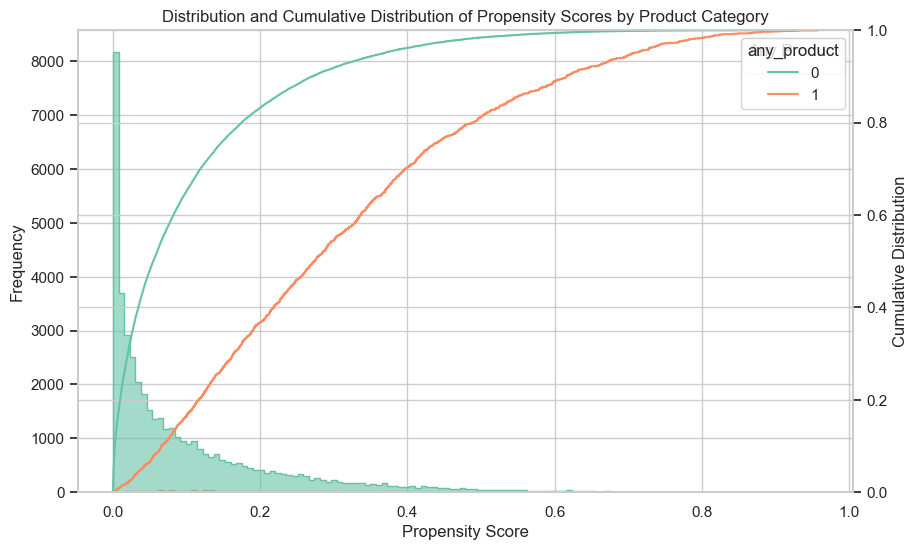

In [17]:
# Visualizes the distribution of propensity scores by product category

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Set the style of the visualization
sns.set(style="whitegrid")

# Create a figure and a set of subplots
plt.figure(figsize=(10, 6))

# First axis: Plot the histogram of propensity scores grouped by 'any_product'
ax1 = sns.histplot(data=df, x="propensity_score", hue="any_product", kde=False, palette="Set2", element="step", alpha=0.6)
ax1.set_xlabel("Propensity Score")
ax1.set_ylabel("Frequency")
plt.legend(title='Any Product', loc='upper right')

# Second axis: Plot the cumulative distribution
ax2 = ax1.twinx()
sns.ecdfplot(data=df, x="propensity_score", hue="any_product", palette="Set2", ax=ax2, stat="proportion")
ax2.set_ylabel('Cumulative Distribution')

# Set the title for the plot
plt.title("Distribution and Cumulative Distribution of Propensity Scores by Product Category")

# Show the plot
plt.show()


In [18]:
# Conducts refined matching of data samples based on propensity scores and MRR, generating paired comparisons between treated and control groups.

# Define the range for propensity score matching
propensity_score_range = 0.01  # Adjust as needed

# Separate treated and control groups
treated = df[df[outcome] == 1]
control = df[df[outcome] == 0]

# Perform initial matching based on propensity score
initial_matches = []
for index, row in treated.iterrows():
    min_score = row["propensity_score"] - propensity_score_range
    max_score = row["propensity_score"] + propensity_score_range
    potential_matches = control[
        (control["propensity_score"] >= min_score)
        & (control["propensity_score"] <= max_score)
    ]
    for pm_index, pm_row in potential_matches.iterrows():
        initial_matches.append({"treated_index": index, "control_index": pm_index})

initial_matched_df = pd.DataFrame(initial_matches)

# Refine matching based on nearest MRR
final_matches = []
for treated_index in treated.index:
    treated_mrr = treated.loc[treated_index, "mrr__total"]
    potential_controls = initial_matched_df[
        initial_matched_df["treated_index"] == treated_index
    ]
    if not potential_controls.empty:
        control_indices = potential_controls["control_index"].values
        control_mrrs = control.loc[control_indices, "mrr__total"]
        nearest_control_index = control_mrrs.sub(treated_mrr).abs().idxmin()
        final_matches.append(
            {"treated_index": treated_index, "control_index": nearest_control_index}
        )

# Create final DataFrame for 1:1 matched pairs
matched_pairs = pd.DataFrame(final_matches)


### Post-Match Balance Check


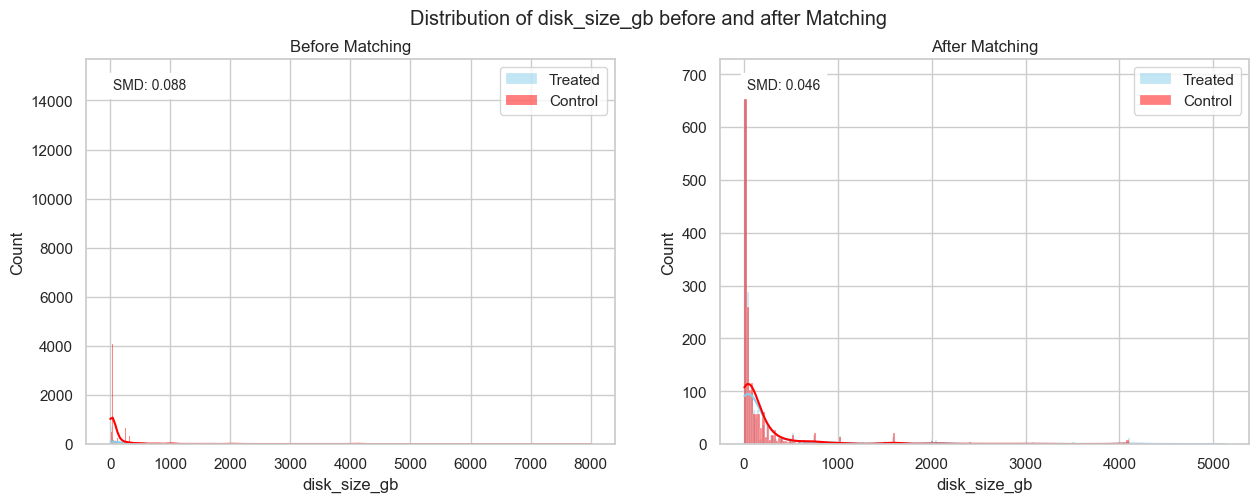

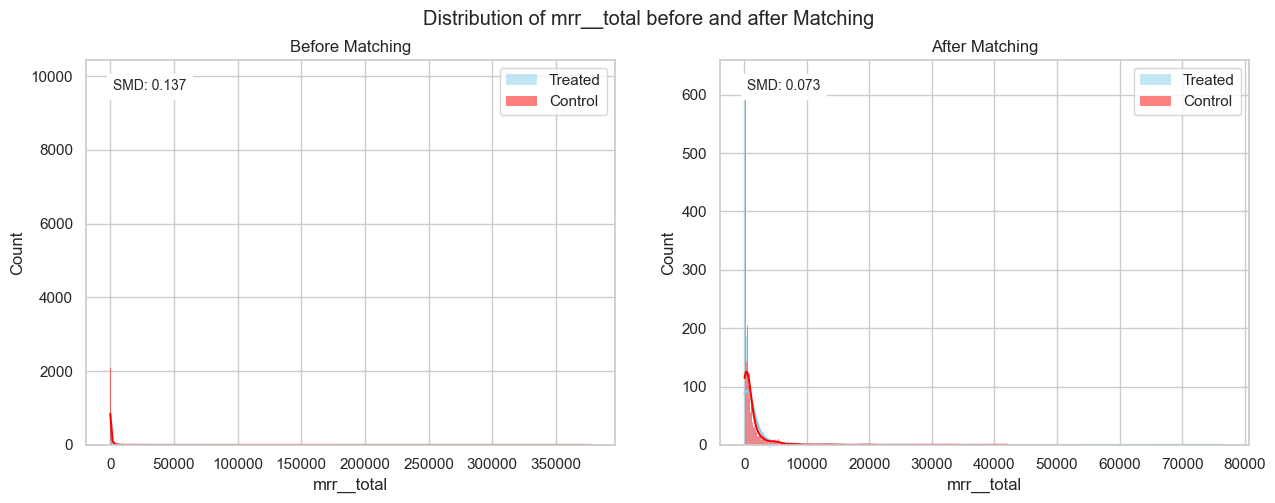

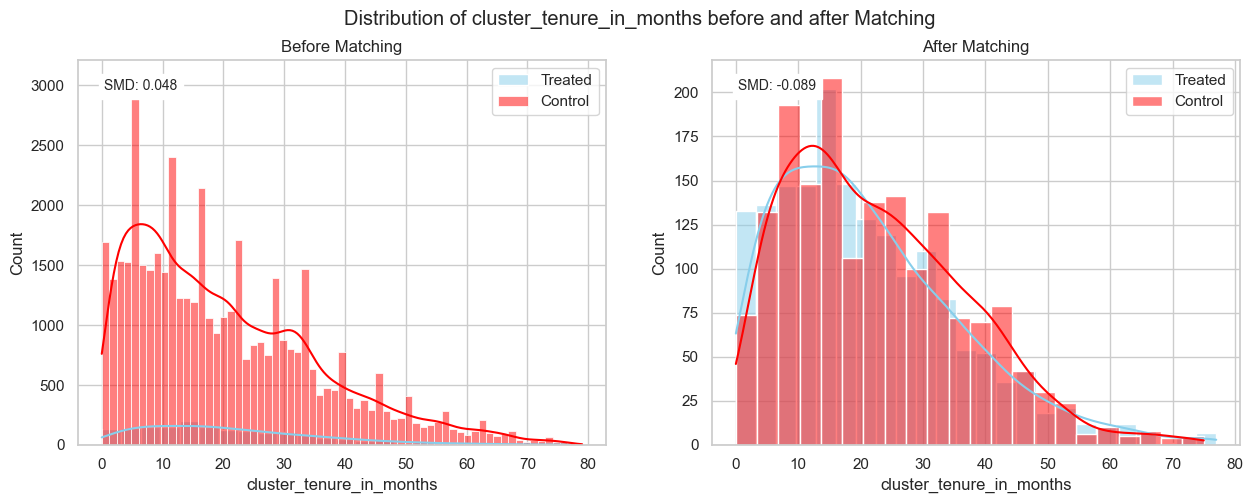

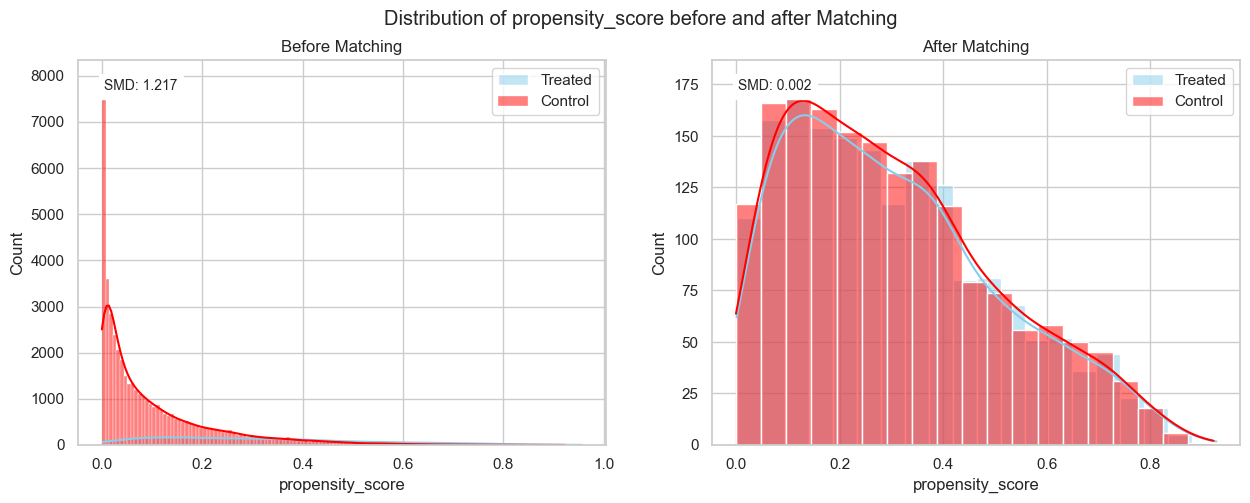

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Function to calculate standardized mean difference
def calculate_smd(group1, group2):
    mean1, mean2 = np.mean(group1), np.mean(group2)
    var1, var2 = np.var(group1, ddof=1), np.var(group2, ddof=1)
    pooled_sd = np.sqrt((var1 + var2) / 2)
    smd = (mean1 - mean2) / pooled_sd
    return smd

# Identify categorical and numerical columns
categorical_features = [col for col in df.columns if df[col].dtype == 'object' and col != outcome]
numerical_features = [col for col in df.columns if col not in categorical_features and col != outcome]

# For each feature, plot the distribution before and after matching
for feature in numerical_features:
    # Set up the matplotlib figure
    fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=False)
    fig.suptitle(f'Distribution of {feature} before and after Matching')

    # Determine bins for the histogram
    bin_edges = 'auto'
    
    # Set alpha for transparency
    alpha_value = 0.5

    # Before matching histograms
    sns.histplot(
        data=df[df[outcome] == 1],
        x=feature,
        color="skyblue",
        label='Treated',
        ax=axes[0],
        bins=bin_edges,
        kde=True,
        alpha=alpha_value
    )
    sns.histplot(
        data=df[df[outcome] == 0],
        x=feature,
        color="red",
        label='Control',
        ax=axes[0],
        bins=bin_edges,
        kde=True,
        alpha=alpha_value
    )

    # Calculate SMD before matching
    smd_before = calculate_smd(df[df[outcome] == 1][feature], df[df[outcome] == 0][feature])

    # After matching histograms - extract feature values for matched treated and control units
    treated_values = df.loc[matched_pairs['treated_index'], feature]
    control_values = df.loc[matched_pairs['control_index'], feature]

    sns.histplot(
        treated_values,
        color="skyblue",
        label='Treated',
        ax=axes[1],
        bins=bin_edges,
        kde=True,
        alpha=alpha_value
    )
    sns.histplot(
        control_values,
        color="red",
        label='Control',
        ax=axes[1],
        bins=bin_edges,
        kde=True,
        alpha=alpha_value
    )

    # Calculate SMD after matching
    smd_after = calculate_smd(treated_values, control_values)

    # Annotate SMD on the plots
    axes[0].annotate(f'SMD: {smd_before:.3f}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=10, 
                     horizontalalignment='left', verticalalignment='top', backgroundcolor='white')
    axes[1].annotate(f'SMD: {smd_after:.3f}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=10, 
                     horizontalalignment='left', verticalalignment='top', backgroundcolor='white')

    axes[0].set_title('Before Matching')
    axes[0].legend()
    axes[1].set_title('After Matching')
    axes[1].legend()

    plt.show()


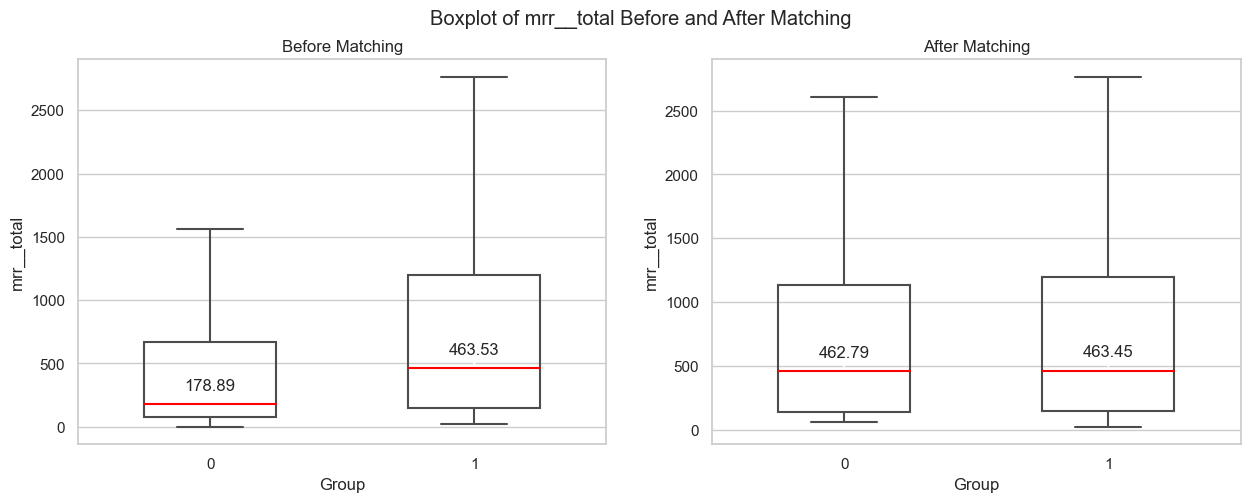

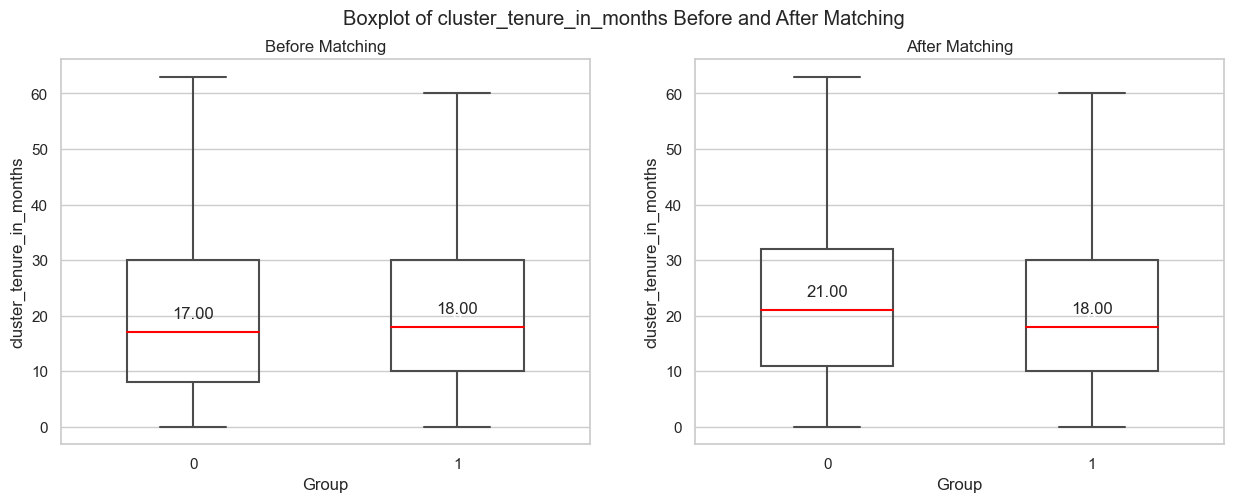

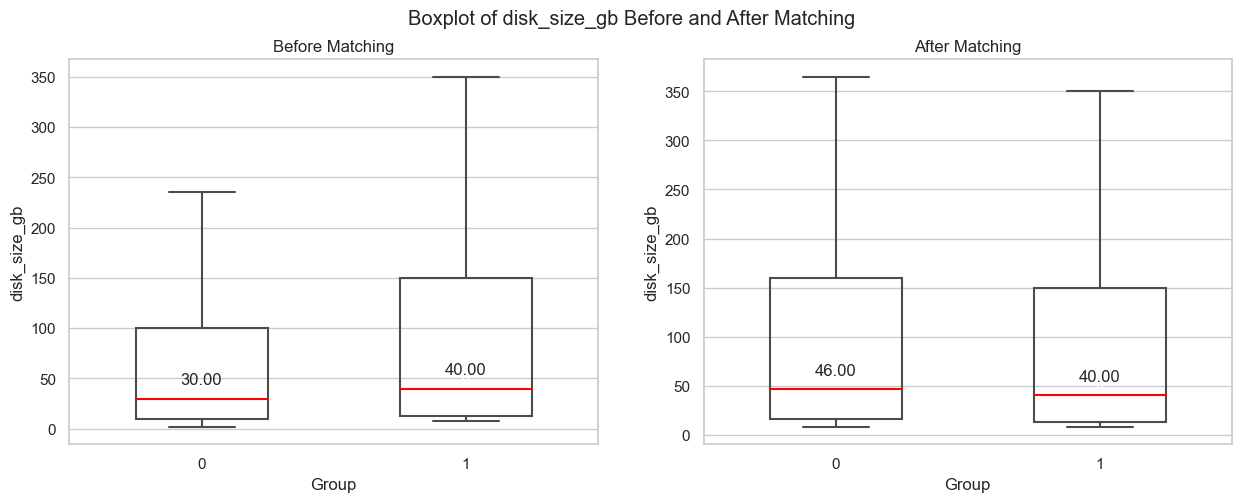

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Numerical features identified from your preprocessing
numerical_features = [
    "mrr__total",
    "cluster_tenure_in_months",
    "disk_size_gb",
]

# Outcome variable
outcome = "any_product"

# For each numerical feature, create boxplots before and after matching
for feature in numerical_features:
    # Set up the matplotlib figure
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle(f"Boxplot of {feature} Before and After Matching")

    # Boxplot before matching
    sns.boxplot(
        x=outcome,
        y=feature,
        data=df,
        order=[0, 1],  # Control (0) on the left, Treated (1) on the right
        palette={0: "red", 1: "skyblue"},
        ax=axes[0],
        showfliers=False,  # Do not show outliers
        linewidth=1.5,
        boxprops=dict(facecolor="none"),
        width=0.5,
        medianprops=dict(color="red"),
    )
    axes[0].set_title("Before Matching")
    axes[0].set_xlabel("Group")
    axes[0].set_ylabel(feature)

    # Annotate median values before matching
    for group in [0, 1]:
        median = df[df[outcome] == group][feature].median()
        axes[0].annotate(
            f"{median:.2f}",
            xy=(group, median),
            xytext=(0, 10),
            textcoords="offset points",
            arrowprops=dict(arrowstyle="->"),
            ha="center",
        )

    # Extracting matched treatment and control values
    treated_values = df.loc[matched_pairs["treated_index"], feature]
    control_values = df.loc[matched_pairs["control_index"], feature]

    # Correctly labeling 'Control' and 'Treated' in matched_data
    matched_data = pd.DataFrame(
        {
            feature: pd.concat([control_values, treated_values], ignore_index=True),
            "Group": [0] * len(control_values) + [1] * len(treated_values),
        }
    )

    # Boxplot after matching
    sns.boxplot(
        x="Group",
        y=feature,
        data=matched_data,
        order=[0, 1],  # Ensuring correct order: Control (0), then Treated (1)
        palette={0: "red", 1: "skyblue"},
        ax=axes[1],
        showfliers=False,  # Do not show outliers
        linewidth=1.5,
        boxprops=dict(facecolor="none"),
        width=0.5,
        medianprops=dict(color="red"),
    )
    axes[1].set_title("After Matching")
    axes[1].set_xlabel("Group")
    axes[1].set_ylabel(feature)

    # Annotate median values after matching
    for group in [0, 1]:
        median = matched_data[matched_data["Group"] == group][feature].median()
        axes[1].annotate(
            f"{median:.2f}",
            xy=(group, median),
            xytext=(0, 10),
            textcoords="offset points",
            arrowprops=dict(arrowstyle="->"),
            ha="center",
        )

    plt.show()

In [21]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import pandas as pd

# # Numerical features identified from your preprocessing
# numerical_features = [
#     "mrr__total",
#     "cluster_tenure_in_months",
#     "disk_size_gb",
# ]

# # Outcome variable
# outcome = "any_product"

# # For each numerical feature, create boxplots before and after matching
# for feature in numerical_features:
#     # Set up the matplotlib figure
#     fig, axes = plt.subplots(1, 2, figsize=(15, 5))
#     fig.suptitle(f"Boxplot of {feature} Before and After Matching")

#     # Boxplot before matching
#     sns.boxplot(
#         x=outcome,
#         y=feature,
#         data=df,
#         order=[0, 1],  # Control (0) on the left, Treated (1) on the right
#         palette={0: "red", 1: "skyblue"},
#         ax=axes[0],
#         showfliers=False,  # Do not show outliers
#         linewidth=1.5,
#         boxprops=dict(facecolor="none"),
#         width=0.5,
#         medianprops=dict(color="red"),
#     )
#     axes[0].set_title("Before Matching")
#     axes[0].set_xlabel("Group")
#     axes[0].set_ylabel(feature)

#     # Extracting matched treatment and control values
#     treated_values = df.loc[matched_pairs["treated_index"], feature]
#     control_values = df.loc[matched_pairs["control_index"], feature]

#     # Correctly labeling 'Control' and 'Treated' in matched_data
#     matched_data = pd.DataFrame(
#         {
#             feature: pd.concat([control_values, treated_values], ignore_index=True),
#             "Group": [0] * len(control_values) + [1] * len(treated_values),
#         }
#     )

#     # Boxplot after matching
#     sns.boxplot(
#         x="Group",
#         y=feature,
#         data=matched_data,
#         order=[0, 1],  # Ensuring correct order: Control (0), then Treated (1)
#         palette={0: "red", 1: "skyblue"},
#         ax=axes[1],
#         showfliers=False,  # Do not show outliers
#         linewidth=1.5,
#         boxprops=dict(facecolor="none"),
#         width=0.5,
#         medianprops=dict(color="red"),
#     )
#     axes[1].set_title("After Matching")
#     axes[1].set_xlabel("Group")
#     axes[1].set_ylabel(feature)

#     plt.show()

/var/folders/hf/yzqj_9c16qq6ktd52cj47flw0000gp/T/ipykernel_28029/181258789.py:86: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


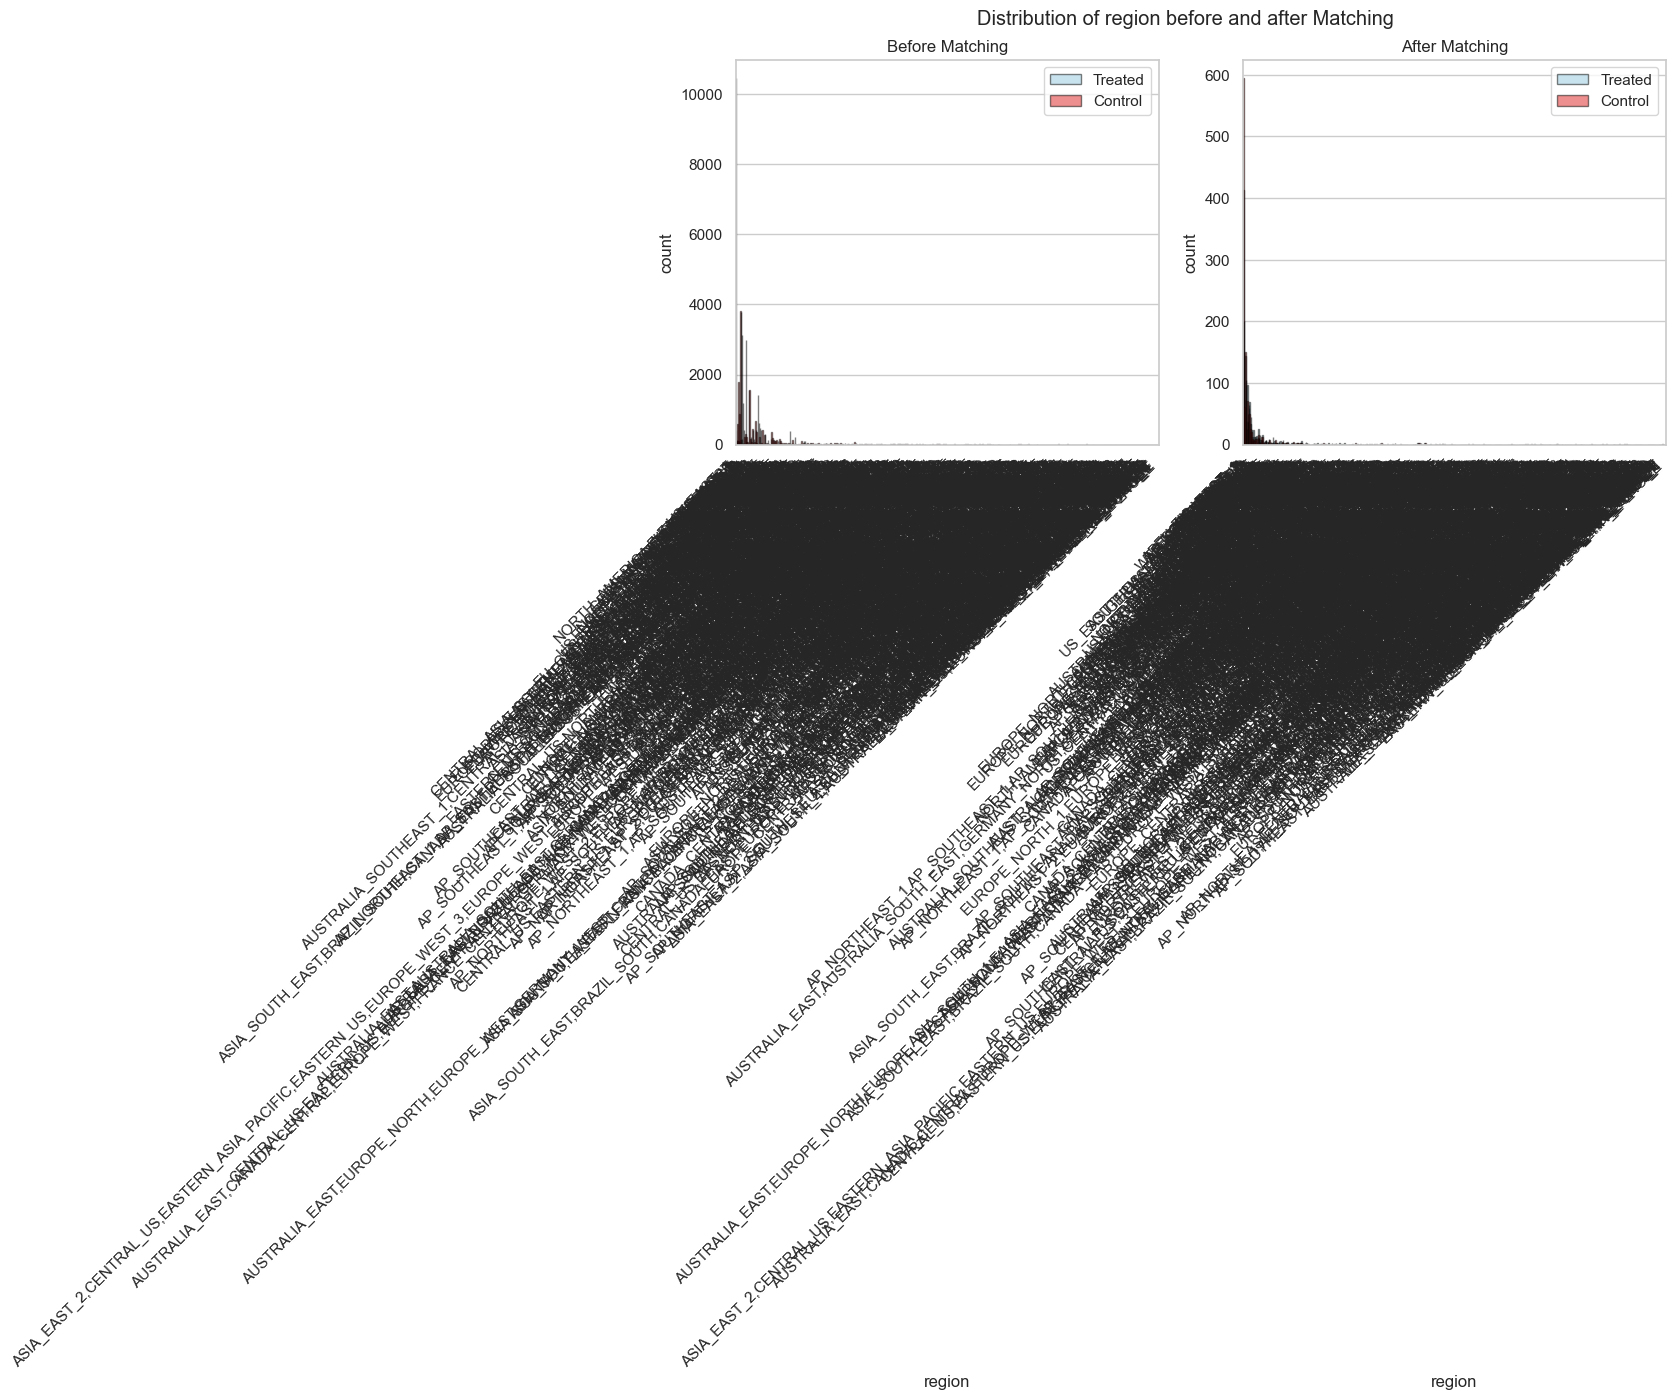

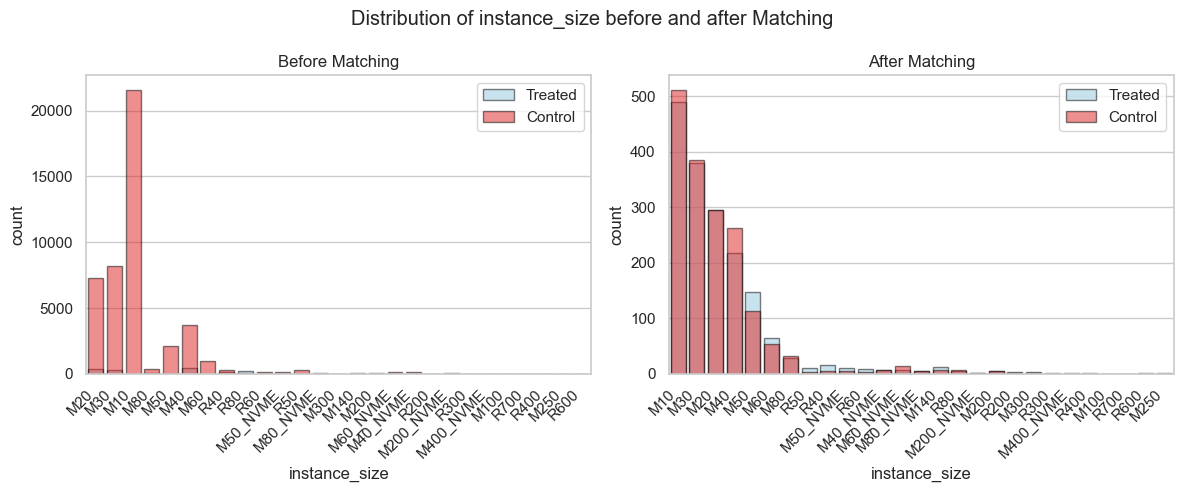

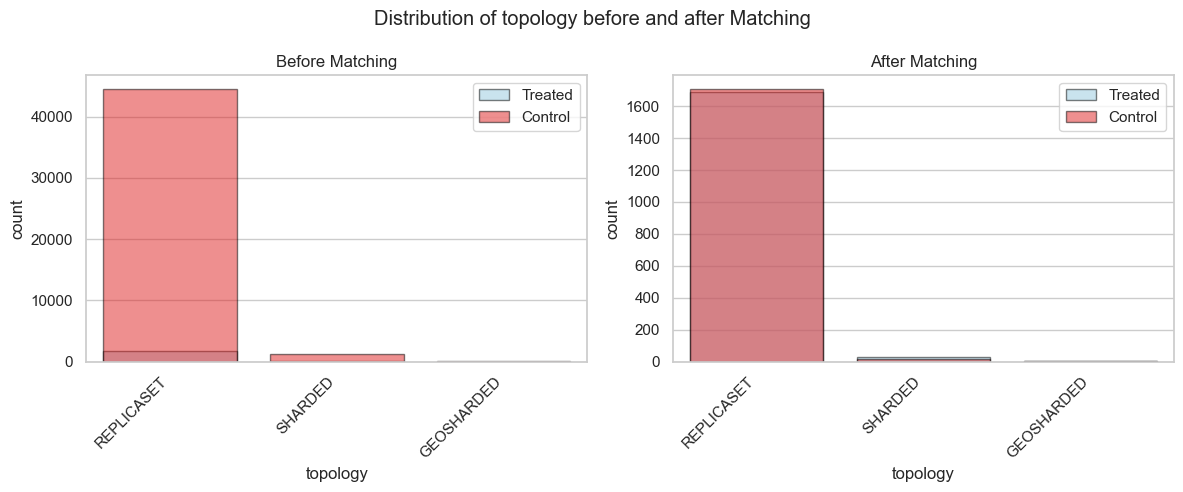

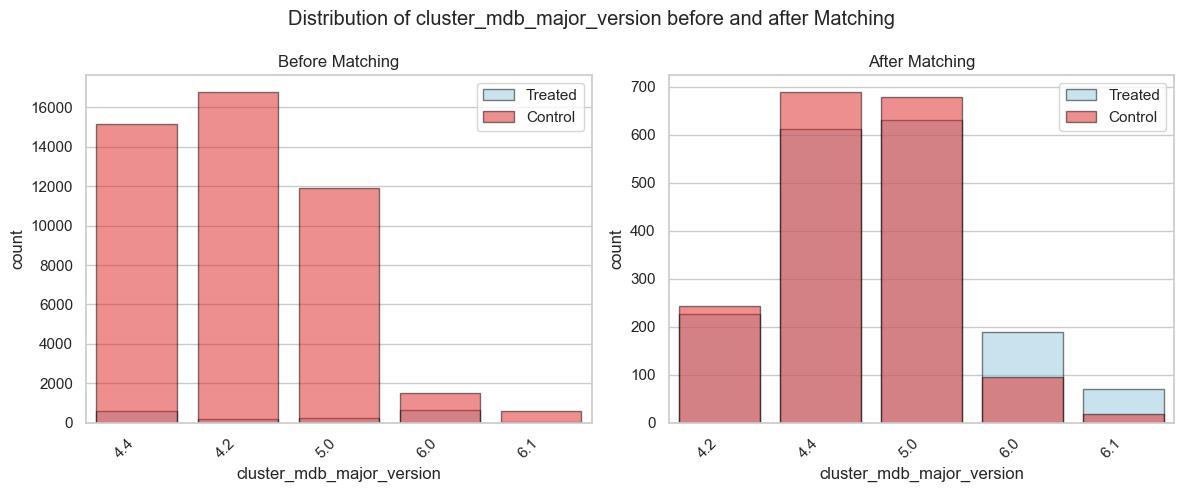

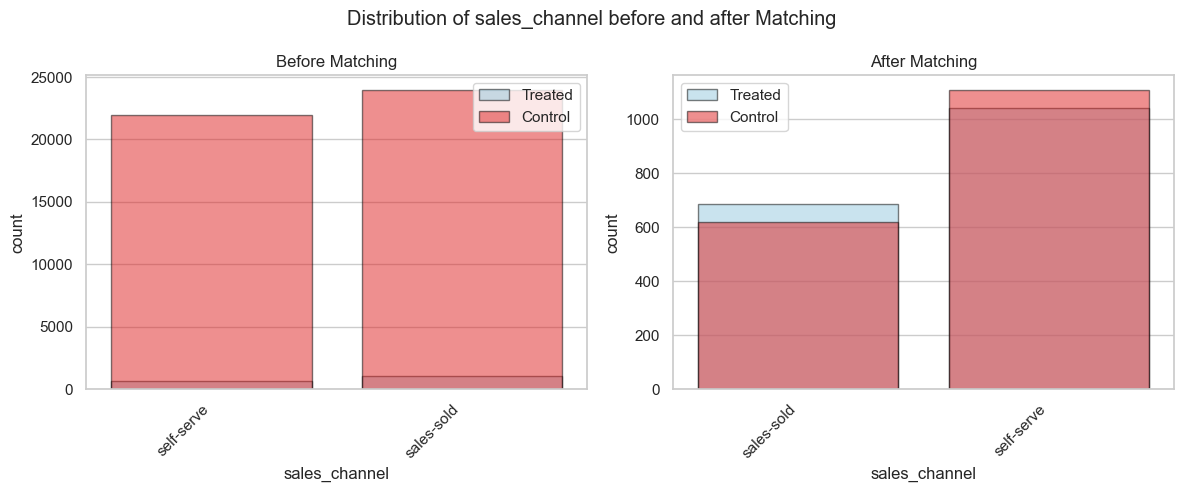

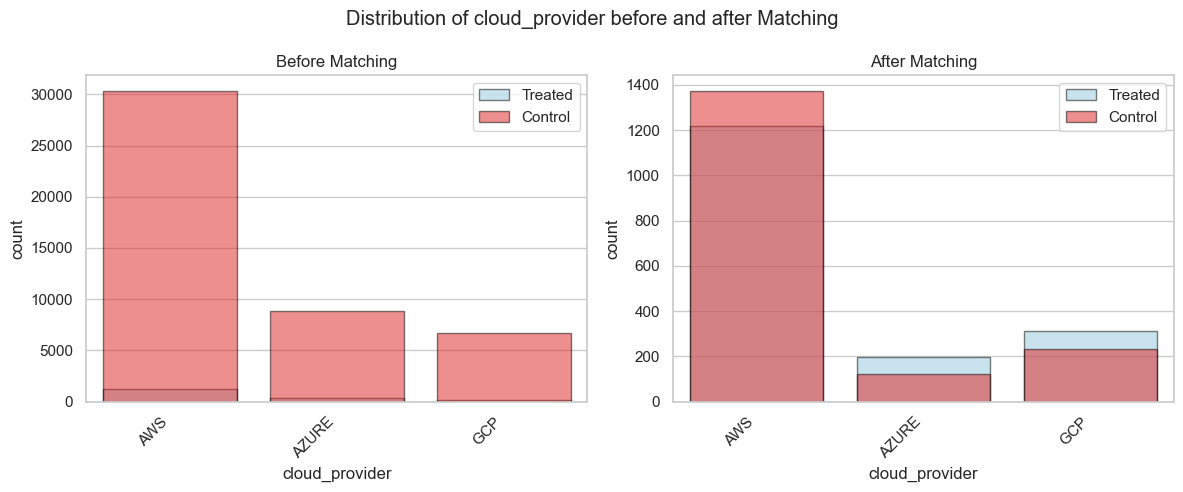

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

categorical_features = [
    "region",
    "instance_size",
    "topology",
    "cluster_mdb_major_version",
    "sales_channel",
    "cloud_provider",
]

for feature in categorical_features:
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=False)
    fig.suptitle(f"Distribution of {feature} before and after Matching")
    alpha_value = 0.5

    # Define border properties
    border_color = "black"
    border_width = 1

    # Before matching
    sns.countplot(
        x=feature,
        data=df[df[outcome] == 1],
        color="skyblue",
        edgecolor=border_color,
        linewidth=border_width,
        label="Treated",
        alpha=alpha_value,
        ax=axes[0],
    )
    sns.countplot(
        x=feature,
        data=df[df[outcome] == 0],
        color="red",
        edgecolor=border_color,
        linewidth=border_width,
        label="Control",
        alpha=alpha_value,
        ax=axes[0],
    )

    # Get the order of categories based on the frequency before matching
    categories_order = df[feature].value_counts().index.tolist()

    # After matching for Treated
    treated_indices = matched_pairs["treated_index"]
    treated_values = df.loc[treated_indices, feature].reset_index(drop=True)
    sns.countplot(
        x=treated_values,
        color="skyblue",
        edgecolor=border_color,
        linewidth=border_width,
        label="Treated",
        alpha=alpha_value,
        ax=axes[1],
        order=categories_order,
    )

    # After matching for Control
    control_indices = matched_pairs["control_index"]
    control_values = df.loc[control_indices, feature].reset_index(drop=True)
    sns.countplot(
        x=control_values,
        color="red",
        edgecolor=border_color,
        linewidth=border_width,
        label="Control",
        alpha=alpha_value,
        ax=axes[1],
        order=categories_order,
    )

    axes[0].set_title("Before Matching")
    axes[0].legend()
    axes[1].set_title("After Matching")
    axes[1].legend()

    for ax in axes:
        ax.set_xticklabels(
            ax.get_xticklabels(), rotation=45, horizontalalignment="right"
        )

    plt.tight_layout()
    plt.show()

### Conclusion with Plots


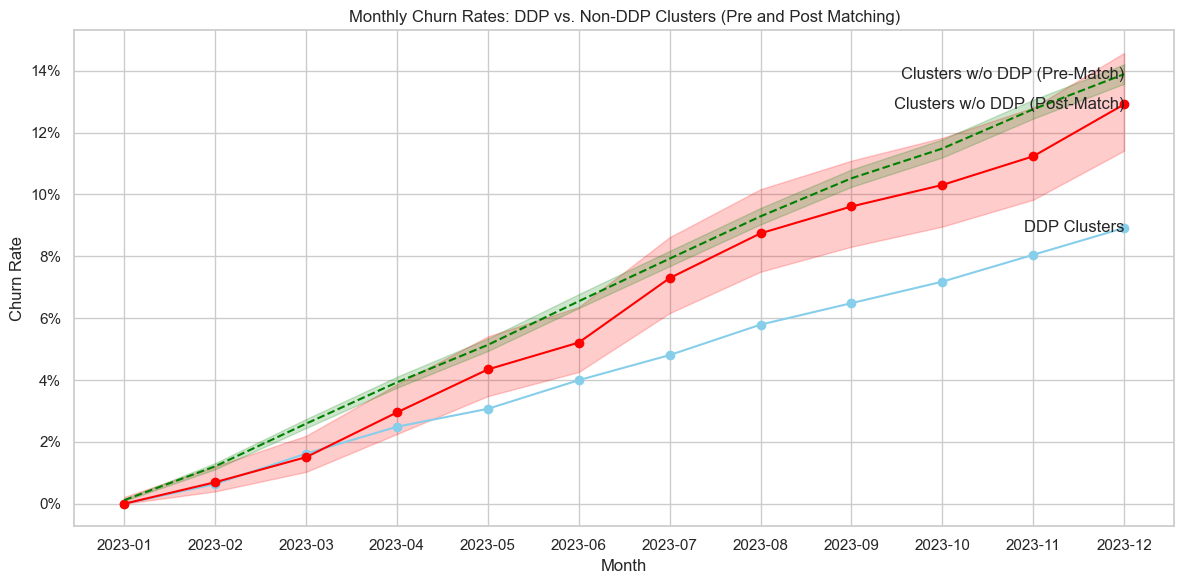

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from statsmodels.stats.proportion import proportion_confint

# Create a copy of the original DataFrame
df_with_churn = df_backup.copy()

# Get the monthly churn columns
churn_columns = [
    col for col in df_with_churn.columns if col.startswith("churn_ind_2023")
]

# Initialize a DataFrame to store the churn rates and confidence intervals for each group by month
churn_rates_by_group = pd.DataFrame(
    index=churn_columns,
    columns=[
        "Treated",
        "Control",
        "Treated_lower_CI",
        "Treated_upper_CI",
        "Control_lower_CI",
        "Control_upper_CI",
    ],
)

# Calculate churn rates and confidence intervals for each month
for month in churn_columns:
    treated_churn = df_with_churn.loc[matched_pairs["treated_index"], month].sum()
    control_churn = df_with_churn.loc[matched_pairs["control_index"], month].sum()
    n_treated = len(matched_pairs["treated_index"])
    n_control = len(matched_pairs["control_index"])

    churn_rate_treated = treated_churn / n_treated
    churn_rate_control = control_churn / n_control

    treated_lower_CI, treated_upper_CI = proportion_confint(
        treated_churn, n_treated, method="wilson"
    )
    control_lower_CI, control_upper_CI = proportion_confint(
        control_churn, n_control, method="wilson"
    )

    churn_rates_by_group.loc[month] = [
        churn_rate_treated,
        churn_rate_control,
        treated_lower_CI,
        treated_upper_CI,
        control_lower_CI,
        control_upper_CI,
    ]

# Convert indices and columns to numeric as required for plotting
churn_rates_by_group = churn_rates_by_group.apply(pd.to_numeric)

# Reset the index to get the months as a column
churn_rates_by_group.reset_index(inplace=True)
churn_rates_by_group.rename(columns={"index": "Month"}, inplace=True)

# Convert 'Month' to a more readable format and ensure it is a string for plotting
churn_rates_by_group["Month"] = (
    churn_rates_by_group["Month"].str.replace("churn_ind_", "").str.replace("_", "-")
)

# Calculate original churn rate for any_product=0 for each month before matching
original_churn_rates = df_with_churn[df_with_churn["any_product"] == 0][
    churn_columns
].mean()

# Color settings
colors = {
    "DDP Clients Churn Rate": "skyblue",
    "Post-Match Non-DDP Churn Rate": "red",
    "Pre-Match": "green",
}

# Plot the line chart with confidence intervals
plt.figure(figsize=(12, 6))

# Set y-axis formatter for percentages
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{y:.0%}"))

# Plotting DDP Clients Churn Rate
plt.plot(
    churn_rates_by_group["Month"],
    churn_rates_by_group["Treated"],
    marker="o",
    color=colors["DDP Clients Churn Rate"],
)

# Plotting Post-Match Non-DDP Churn Rate
plt.plot(
    churn_rates_by_group["Month"],
    churn_rates_by_group["Control"],
    marker="o",
    color=colors["Post-Match Non-DDP Churn Rate"],
)
plt.fill_between(
    churn_rates_by_group["Month"],
    churn_rates_by_group["Control_lower_CI"],
    churn_rates_by_group["Control_upper_CI"],
    alpha=0.2,
    color=colors["Post-Match Non-DDP Churn Rate"],
)

# Plotting Pre-Match Non-DDP Churn Rate
plt.plot(
    churn_rates_by_group["Month"],
    original_churn_rates,
    linestyle="--",
    color=colors["Pre-Match"],
)
# Calculate and Add Confidence Interval for Pre-Match Non-DDP Churn Rate
pre_match_lower_CI, pre_match_upper_CI = proportion_confint(
    original_churn_rates * len(df_with_churn[df_with_churn["any_product"] == 0]),
    len(df_with_churn[df_with_churn["any_product"] == 0]),
    method="wilson",
)
plt.fill_between(
    churn_rates_by_group["Month"],
    pre_match_lower_CI,
    pre_match_upper_CI,
    alpha=0.2,
    color=colors["Pre-Match"],
)

# Add Descriptions directly next to lines with transparent background
plt.text(
    churn_rates_by_group["Month"].iloc[-1],
    churn_rates_by_group["Treated"].iloc[-1],
    "DDP Clusters",
    va="center",
    ha="right",
    bbox=dict(facecolor="none", edgecolor="none"),
)
plt.text(
    churn_rates_by_group["Month"].iloc[-1],
    churn_rates_by_group["Control"].iloc[-1],
    "Clusters w/o DDP (Post-Match)",
    va="center",
    ha="right",
    bbox=dict(facecolor="none", edgecolor="none"),
)
plt.text(
    churn_rates_by_group["Month"].iloc[-1],
    original_churn_rates.iloc[-1],
    "Clusters w/o DDP (Pre-Match)",
    va="center",
    ha="right",
    bbox=dict(facecolor="none", edgecolor="none"),
)

# Plot settings
plt.title("Monthly Churn Rates: DDP vs. Non-DDP Clusters (Pre and Post Matching)")
plt.xlabel("Month")
plt.ylabel("Churn Rate")
plt.tight_layout()
plt.show()

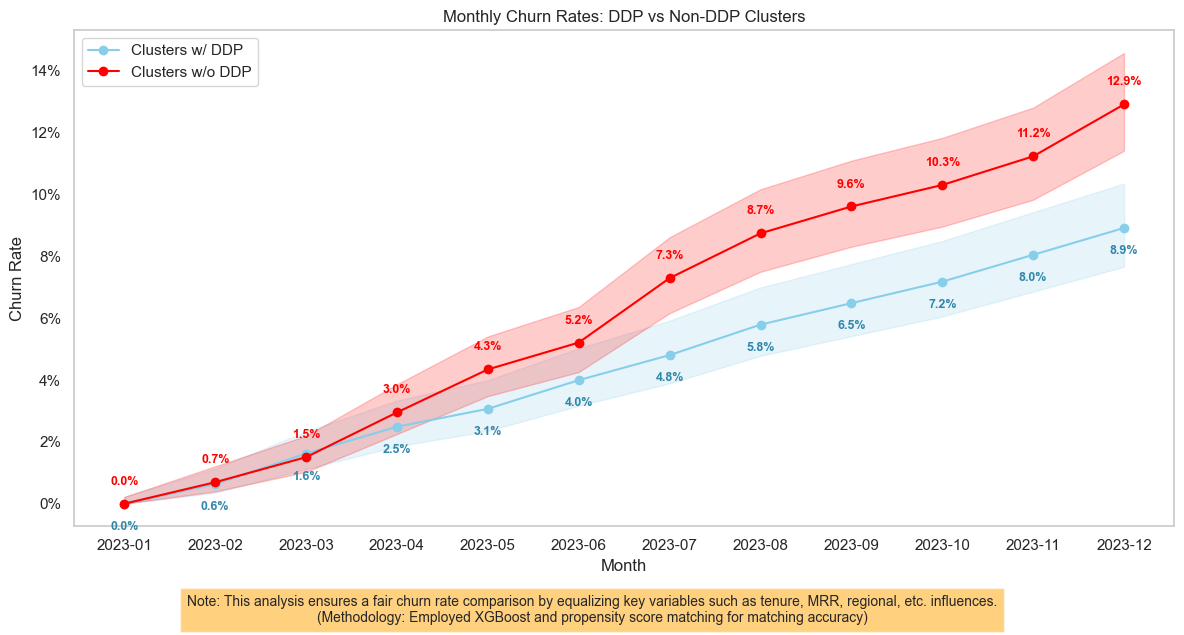

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from statsmodels.stats.proportion import proportion_confint

# Create a copy of the original DataFrame and get monthly churn columns
df_with_churn = df_backup.copy()
churn_columns = [col for col in df_with_churn.columns if col.startswith("churn_ind_2023")]

# Function to calculate churn rate and confidence intervals
def calculate_churn_rates_and_ci(data, indices, method='wilson'):
    churn = data.loc[indices].sum()
    n = len(indices)
    rate = churn / n
    lower_ci, upper_ci = proportion_confint(churn, n, method=method)
    return rate, lower_ci, upper_ci

# Calculating churn rates and confidence intervals
churn_data = []
for month in churn_columns:
    treated_rate, treated_lower_ci, treated_upper_ci = calculate_churn_rates_and_ci(df_with_churn[month], matched_pairs["treated_index"])
    control_rate, control_lower_ci, control_upper_ci = calculate_churn_rates_and_ci(df_with_churn[month], matched_pairs["control_index"])
    churn_data.append([treated_rate, control_rate, treated_lower_ci, treated_upper_ci, control_lower_ci, control_upper_ci])

# Creating DataFrame for churn rates and confidence intervals
churn_rates_by_group = pd.DataFrame(churn_data, index=churn_columns, columns=["Treated", "Control", "Treated_lower_CI", "Treated_upper_CI", "Control_lower_CI", "Control_upper_CI"])
churn_rates_by_group = churn_rates_by_group.apply(pd.to_numeric).reset_index()
churn_rates_by_group.rename(columns={"index": "Month"}, inplace=True)
churn_rates_by_group["Month"] = churn_rates_by_group["Month"].str.replace("churn_ind_", "").str.replace("_", "-")

# Calculate original churn rate before matching
original_churn_rates = df_with_churn[df_with_churn["any_product"] == 0][churn_columns].mean()

# Plot settings
plt.figure(figsize=(12, 6))
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{y:.0%}"))

# Plotting with loop
group_details = [('Treated', 'skyblue', 'Clusters w/ DDP'), ('Control', 'red', 'Clusters w/o DDP')]
for group, color, label in group_details:
    plt.plot(churn_rates_by_group["Month"], churn_rates_by_group[group], marker="o", label=label, color=color)
    plt.fill_between(churn_rates_by_group["Month"], churn_rates_by_group[f"{group}_lower_CI"], churn_rates_by_group[f"{group}_upper_CI"], alpha=0.2, color=color)
    # Data labels
    for i, rate in enumerate(churn_rates_by_group[group]):
        y_offset = 0.07 * max(churn_rates_by_group[group])
        text_color = '#3186a9' if color == 'skyblue' else 'red'
        va = 'bottom' if color == 'skyblue' else 'top'
        plt.text(churn_rates_by_group["Month"][i], rate - 1.5 * y_offset if color == 'skyblue' else rate + y_offset, f"{rate:.1%}", ha='center', va=va, fontsize=9, fontweight='bold', color=text_color)

# Final plot adjustments
plt.title("Monthly Churn Rates: DDP vs Non-DDP Clusters")
plt.xlabel("Month")
plt.ylabel("Churn Rate")
plt.legend(loc="upper left")
plt.figtext(0.5, -0.05, "Note: This analysis ensures a fair churn rate comparison by equalizing key variables such as tenure, MRR, regional, etc. influences.\n(Methodology: Employed XGBoost and propensity score matching for matching accuracy)", ha="center", fontsize=10, bbox={"facecolor": "orange", "alpha": 0.5, "pad": 5})
plt.tight_layout()
plt.grid(False)
plt.show()


In [25]:
import pandas as pd
from scipy.stats import chi2_contingency
from statsmodels.stats.proportion import proportion_confint

month = "churn_ind_2023_11"  # Specify the month

# Calculate the churn for treated and control groups
treated_churn = df_with_churn.loc[matched_pairs["treated_index"], month].sum()
control_churn = df_with_churn.loc[matched_pairs["control_index"], month].sum()

# Calculate the total number of treated and control
n_treated = len(matched_pairs["treated_index"])
n_control = len(matched_pairs["control_index"])

# Calculate churn rates
churn_rate_treated = treated_churn / n_treated
churn_rate_control = control_churn / n_control

# Calculate confidence intervals
treated_lower_CI, treated_upper_CI = proportion_confint(
    treated_churn, n_treated, method="wilson"
)
control_lower_CI, control_upper_CI = proportion_confint(
    control_churn, n_control, method="wilson"
)

# Construct the contingency table
contingency_table = [
    [treated_churn, n_treated - treated_churn],
    [control_churn, n_control - control_churn],
]

# Perform the chi-square test
chi2_stat, p_value, _, _ = chi2_contingency(contingency_table)

# Simple output
print("November 2023 Churn Analysis")
print("----------------------------")
print(
    f"Treated Group Churn Rate: {churn_rate_treated:.2%} (CI: {treated_lower_CI:.2%} to {treated_upper_CI:.2%})"
)
print(
    f"Control Group Churn Rate: {churn_rate_control:.2%} (CI: {control_lower_CI:.2%} to {control_upper_CI:.2%})"
)
print("\nChi-square Test:")
print(f"Statistic: {chi2_stat:.2f}, P-value: {p_value:.4f}")

# Interpretation
if p_value < 0.05:
    print("Result: Significant difference in churn rates between groups.")
else:
    print("Result: No significant difference in churn rates between groups.")

November 2023 Churn Analysis
----------------------------
Treated Group Churn Rate: 8.05% (CI: 6.86% to 9.43%)
Control Group Churn Rate: 11.23% (CI: 9.83% to 12.81%)

Chi-square Test:
Statistic: 9.69, P-value: 0.0019
Result: Significant difference in churn rates between groups.
